# 1. Import Libraries

In [1]:
# Calculate number
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Handling Outlier
from feature_engine.outliers import Winsorizer

# Scikit-Learn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA

# Model Saving
import pickle
import json

# Suppress All Warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Data Loading

In [2]:
# Data Load
df_ori = pd.read_csv('data_clean.csv')

# Just in case there is original data
df = df_ori.copy()

In [3]:
# Show top 10 data
df.head(10)

,age,job,marital,education,has_credit,balance,housing_loan,loan,contact,day,month,duration,campaign,days_passed,previous,outcome_passed,subscribed
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,october,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,april,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,juny,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,february,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,april,313,1,147,2,failure,no


In [4]:
# Show data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             4521 non-null   int64 
 1   job             4521 non-null   object
 2   marital         4521 non-null   object
 3   education       4521 non-null   object
 4   has_credit      4521 non-null   object
 5   balance         4521 non-null   int64 
 6   housing_loan    4521 non-null   object
 7   loan            4521 non-null   object
 8   contact         4521 non-null   object
 9   day             4521 non-null   int64 
 10  month           4521 non-null   object
 11  duration        4521 non-null   int64 
 12  campaign        4521 non-null   int64 
 13  days_passed     4521 non-null   int64 
 14  previous        4521 non-null   int64 
 15  outcome_passed  4521 non-null   object
 16  subscribed      4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


# 3. Exploratory Data Analysis (EDA)

# 4. Feature Engineering

In [5]:
df = df.loc[(df['subscribed']=='no')]
df.head()

,age,job,marital,education,has_credit,balance,housing_loan,loan,contact,day,month,duration,campaign,days_passed,previous,outcome_passed,subscribed
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,october,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,april,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,juny,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## 4.1 - Splitting Feature

In [6]:
# Splitting numeric columns and categorical columns

num_columns = df.select_dtypes(include=np.number).columns.tolist()
cat_columns = df.select_dtypes(include=['object']).columns.tolist()

df_num = df[num_columns]
df_cat = df[cat_columns]

print('Num Columns : ', num_columns)
print('Cat Columns : ', cat_columns)

Num Columns :  ['age', 'balance', 'day', 'duration', 'campaign', 'days_passed', 'previous']
Cat Columns :  ['job', 'marital', 'education', 'has_credit', 'housing_loan', 'loan', 'contact', 'month', 'outcome_passed', 'subscribed']


## 4.2 - Feature Scaling

In [7]:
# Feature scaling

scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_num)

## 4.3 - PCA

Text(0, 0.5, 'Eigenvalues')

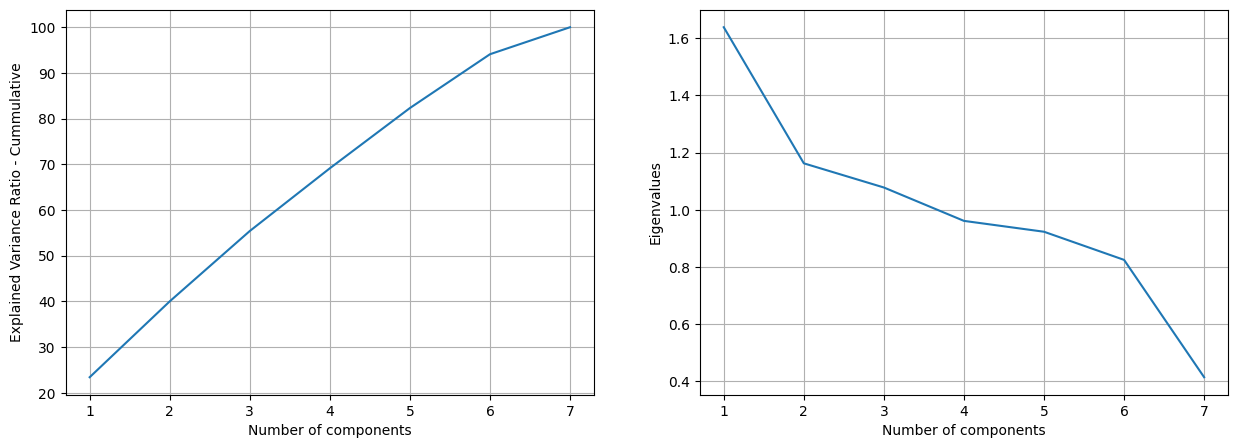

In [8]:
# Dimensionality Reduction using PCA

pca = PCA()
pca.fit(df_num_scaled)

# Plot the Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, 8), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

# Plot the Eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, 8), pca.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

In [9]:
# Check the number of features if we want to retain 95 % of the information

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
num_features

7

In [10]:
# Let's train the model with 95 % of the original dataset information

pca = PCA(n_components=3)
pca.fit(df_num_scaled)

df_num_scaled_pca = pca.transform(df_num_scaled)

## 4.4 - Merge Data

In [11]:
# Concate columns

df_final = np.concatenate([df_num_scaled_pca, df_cat], axis=1)
df_final = pd.DataFrame(df_final, columns=[['PCA1', 'PCA2', 'PCA3'] + cat_columns])
df_final = df_final.infer_objects()
df_final

,PCA1,PCA2,PCA3,job,marital,education,has_credit,housing_loan,loan,contact,month,outcome_passed,subscribed
0,-0.405982,0.030073,-0.577915,unemployed,married,primary,no,no,no,cellular,october,unknown,no
1,3.884314,0.480054,0.177461,services,married,secondary,no,yes,yes,cellular,may,failure,no
2,2.410110,0.387763,-0.481181,management,single,tertiary,no,yes,no,cellular,april,failure,no
3,-0.138744,-0.690161,-0.549841,management,married,tertiary,no,yes,yes,unknown,juny,unknown,no
4,-0.087616,-1.217904,1.113465,blue-collar,married,secondary,no,yes,no,unknown,may,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.958828,0.926549,-1.208545,services,married,secondary,no,yes,no,cellular,july,unknown,no
3996,-0.248314,-0.820272,0.235508,self-employed,married,tertiary,yes,yes,yes,unknown,may,unknown,no
3997,-1.184298,1.804228,0.795195,technician,married,secondary,no,no,no,cellular,august,unknown,no
3998,2.465239,0.523060,-0.836220,blue-collar,married,secondary,no,no,no,cellular,february,other,no


# 5. Model Definition

In [12]:
# Get the position of categorical columns

index_cat_columns = [df_final.columns.get_loc(col) for col in list(df_final.select_dtypes('object').columns)]

print('Categorical columns        : ', cat_columns)
print('Categorical columns index  : ', index_cat_columns)

Categorical columns        :  ['job', 'marital', 'education', 'has_credit', 'housing_loan', 'loan', 'contact', 'month', 'outcome_passed', 'subscribed']
Categorical columns index  :  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Cluster creation :  1
Cluster creation :  2
Cluster creation :  3
Cluster creation :  4
Cluster creation :  5
Cluster creation :  6


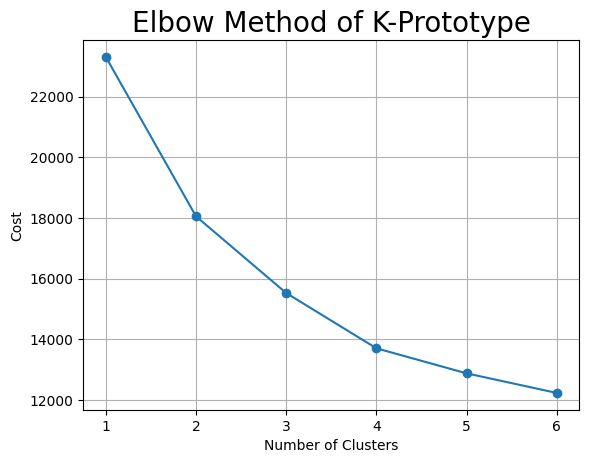

In [13]:
# Find the optimal number of clusters using Elbow Method

max_clusters = 6
cost = []
for k in range(1, max_clusters+1):
  kproto = KPrototypes(n_clusters=k, init='Huang', random_state=42, n_jobs=-1)
  kproto.fit_predict(df_final, categorical=index_cat_columns)
  cost.append(kproto.cost_)
  print('Cluster creation : ', k)

plt.plot(range(1, max_clusters+1), cost, marker ="o")
plt.grid()
plt.title('Elbow Method of K-Prototype', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.show()

# 6. Model Training

In [14]:
# Train with optimal number of clusters

kp = KPrototypes(n_clusters=3, random_state=42)
pred = kp.fit_predict(df_final, categorical=index_cat_columns)
pred

array([1, 0, 0, ..., 2, 0, 0], dtype=uint16)

In [15]:
# Insert clustering result into original dataset

df['cluster'] = pred
df

,age,job,marital,education,has_credit,balance,housing_loan,loan,contact,day,month,duration,campaign,days_passed,previous,outcome_passed,subscribed,cluster
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,october,79,1,-1,0,unknown,no,1
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,april,185,1,330,1,failure,no,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,juny,199,4,-1,0,unknown,no,1
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,july,329,5,-1,0,unknown,no,1
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no,1
4518,57,technician,married,secondary,no,295,no,no,cellular,19,august,151,11,-1,0,unknown,no,2
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,february,129,4,211,3,other,no,0


# 7. Model Analysis

<Axes: >

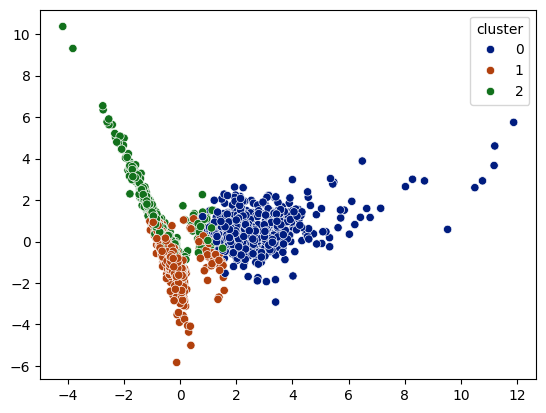

In [16]:
pca_2d = PCA(n_components=3)
pca_2d.fit(df_num_scaled)

df_scaled_pca_2d = pca_2d.fit_transform(df_num_scaled)

sns.scatterplot(x=df_scaled_pca_2d[:,0], y=df_scaled_pca_2d[:,1], hue=df['cluster'], palette='dark')

## 7.1 - Cluster 1

In [17]:
df[df['cluster']==0].describe()

,age,balance,day,duration,campaign,days_passed,previous,cluster
count,524.000000,524.000000,524.000000,524.000000,524.000000,524.000000,524.000000,524.0
mean,40.110687,1538.139313,13.843511,219.026718,2.114504,258.024809,3.311069,0.0
std,9.577058,2999.685245,7.483975,199.739331,1.666869,104.687084,3.235291,0.0
min,20.000000,-1400.000000,1.000000,5.000000,1.000000,2.000000,1.000000,0.0
25%,33.000000,110.250000,7.000000,98.000000,1.000000,175.000000,1.000000,0.0
50%,38.000000,495.000000,14.000000,160.000000,2.000000,264.500000,2.000000,0.0
75%,46.000000,1510.000000,18.000000,265.250000,2.000000,344.000000,4.000000,0.0
max,80.000000,22856.000000,31.000000,1529.000000,11.000000,871.000000,25.000000,0.0


## 7.2 - Cluster 2

In [18]:
df[df['cluster']==1].describe()

,age,balance,day,duration,campaign,days_passed,previous,cluster
count,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.000000,2213.0
mean,37.853592,761.213737,13.831451,275.363308,2.021238,1.746498,0.032987,1.0
std,8.571700,1300.961582,7.789852,238.472550,1.374003,18.563960,0.225611,0.0
min,19.000000,-3313.000000,1.000000,5.000000,1.000000,-1.000000,0.000000,1.0
25%,31.000000,34.000000,7.000000,123.000000,1.000000,-1.000000,0.000000,1.0
50%,36.000000,326.000000,13.000000,210.000000,2.000000,-1.000000,0.000000,1.0
75%,43.000000,973.000000,20.000000,347.000000,2.000000,-1.000000,0.000000,1.0
max,73.000000,11219.000000,31.000000,3025.000000,12.000000,189.000000,4.000000,1.0


In [19]:
df[df['cluster']==2].describe()

,age,balance,day,duration,campaign,days_passed,previous,cluster
count,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.0
mean,46.875693,2472.126683,20.532067,143.500396,4.646081,3.922407,0.060966,2.0
std,10.483157,4626.037450,7.440650,113.331889,4.856645,26.149097,0.333432,0.0
min,19.000000,-2082.000000,1.000000,4.000000,1.000000,-1.000000,0.000000,2.0
25%,39.000000,109.000000,16.000000,70.000000,2.000000,-1.000000,0.000000,2.0
50%,48.000000,687.000000,20.000000,118.000000,3.000000,-1.000000,0.000000,2.0
75%,55.000000,3004.500000,28.000000,187.000000,6.000000,-1.000000,0.000000,2.0
max,86.000000,71188.000000,31.000000,1011.000000,50.000000,232.000000,4.000000,2.0


## 7.3 - Cluster Analysis

Untuk dapat mengidentifikasi perbedaan antara tiap cluster maka akan dilakukan cluster analysis yang mencakup visualisasi dari beberapa feature yang paling mempengaruhi seseorang membuka deposit(subscribe) atau tidak

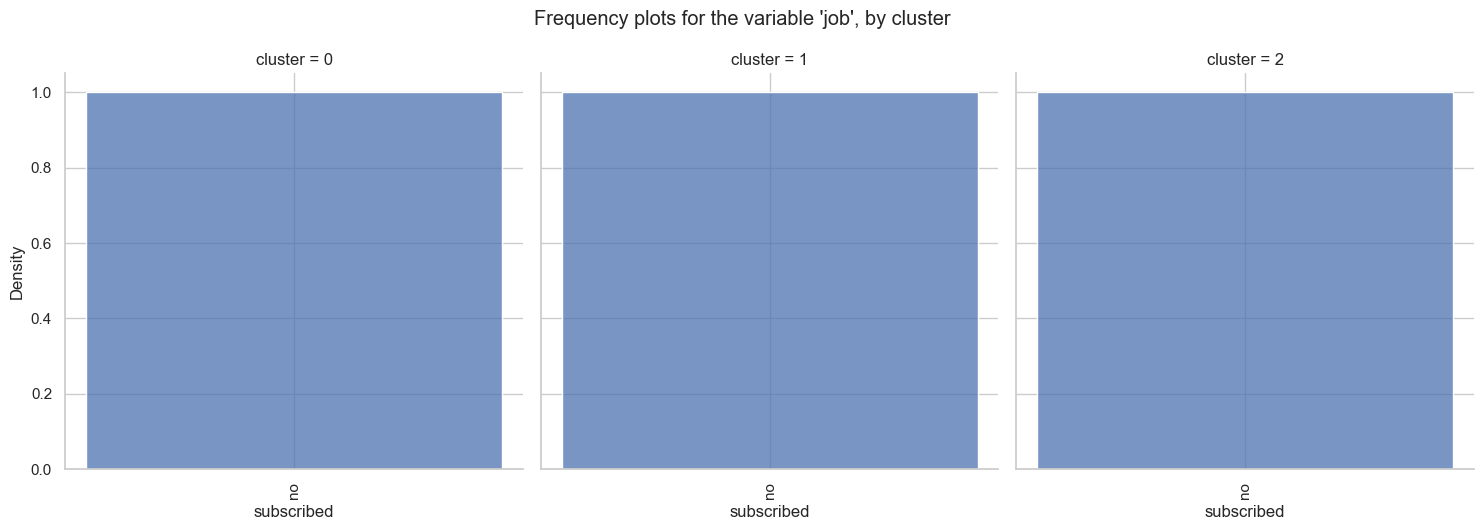

In [48]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='subscribed', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'job', by cluster", y=1.05)
plt.show()

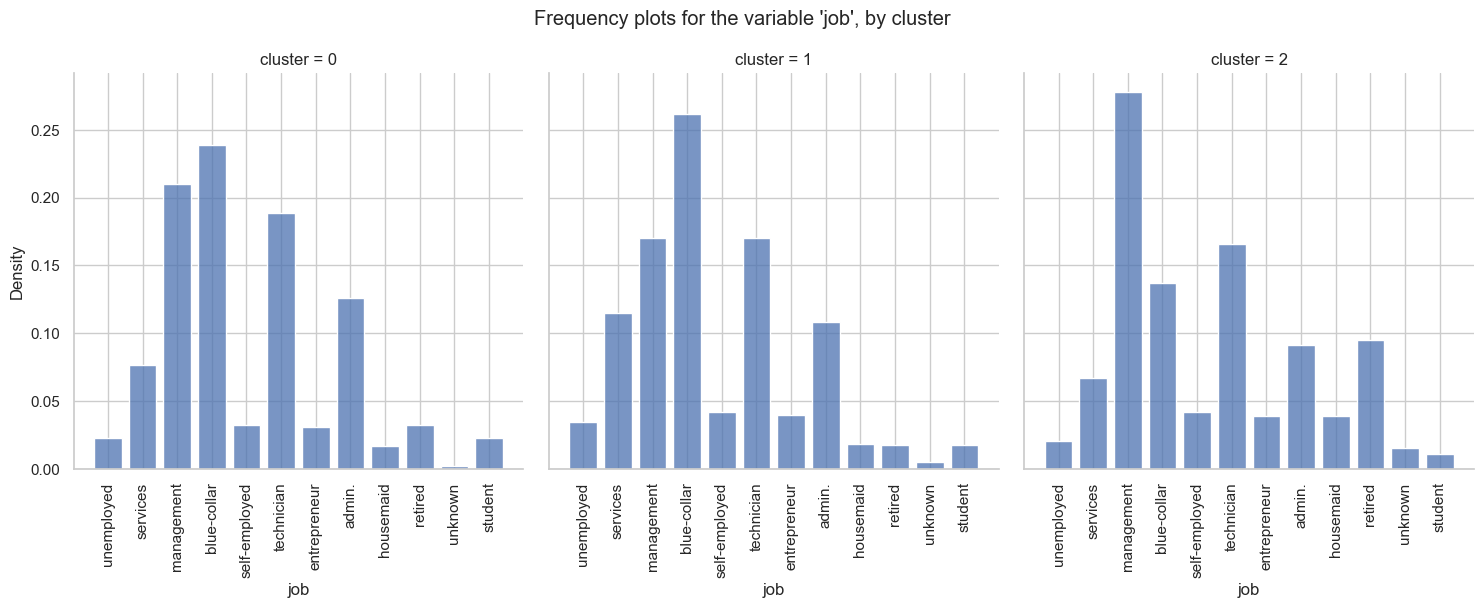

In [20]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='job', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'job', by cluster", y=1.05)
plt.show()

- Cluster 0 mayoritas pekerjaannya merupakan blue collar, managemen dan technician dengan perbedaan persentase yang tidak terlalu besar antara ketiga pekerjaan tersebut
- Cluster 1 mayoritas merupakan blue-collar yang memiliki persentase yang jauh dibandingkan dengan pekerjaan terbesar kedua dan ketiga yaitu management dan technician
- Cluster 2 mayoritas pekerjaannya adalah management dengan persentase yang jauh berbeda dibandingkan pekerjaan kedua yaitu technician

Perbedaan yang mencolok dari ketiga cluster ini adalah, pada cluster 2 pekerjaan retired memiliki persentase terbesar ke empat dibandingkan pekerjaan lainnya sedangkan pada kedua cluster yang lain retired memliki persentase yang kecil dan menempati 3 pekerjaan terbawah

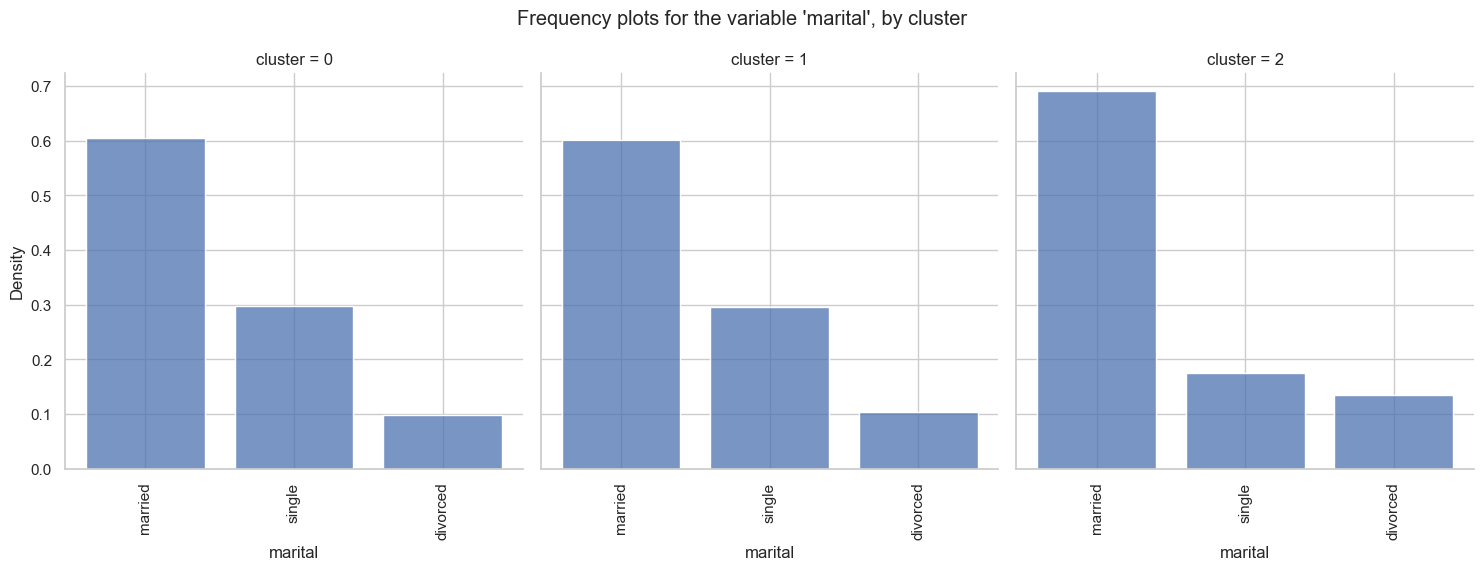

In [21]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='marital', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'marital', by cluster", y=1.05)
plt.show()

Tidak ada perbedaan yang mencolok antara kolom marital antar cluster dimana yang paling banyak di isi oleh mereka yang sudah menikah, meskipun memang di cluster kedua persentase menikah lebih besar dibandingkan cluster yang lain namun secara keseluruhan cluster lumayan mirip

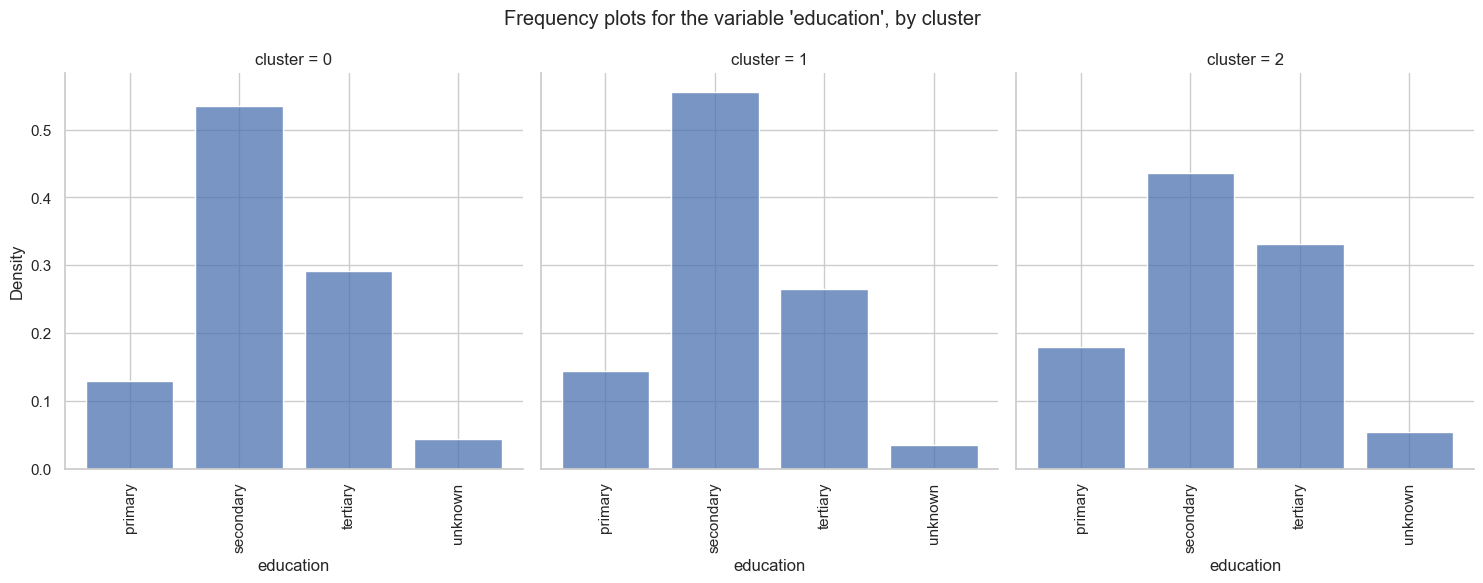

In [22]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='education', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'education', by cluster", y=1.05)
plt.show()

Pada kolom education memiliki perbandingan yang lumayan mirip antar cluster, namun perbedaan yang mencolok adalah pada cluster 2 memiliki orang dengan education tertiary dan primary yang lebih banyak dibandingkan kedua cluster lainnya. Untuk cluster 0 dan 1 di dominasi oleh mereka dengan tingkatan education secondary begitupun dengan cluster 2 namun perbedaan antara secondary dan tertiary di cluster 2 tidak sebesar pada cluster 0 dan 1

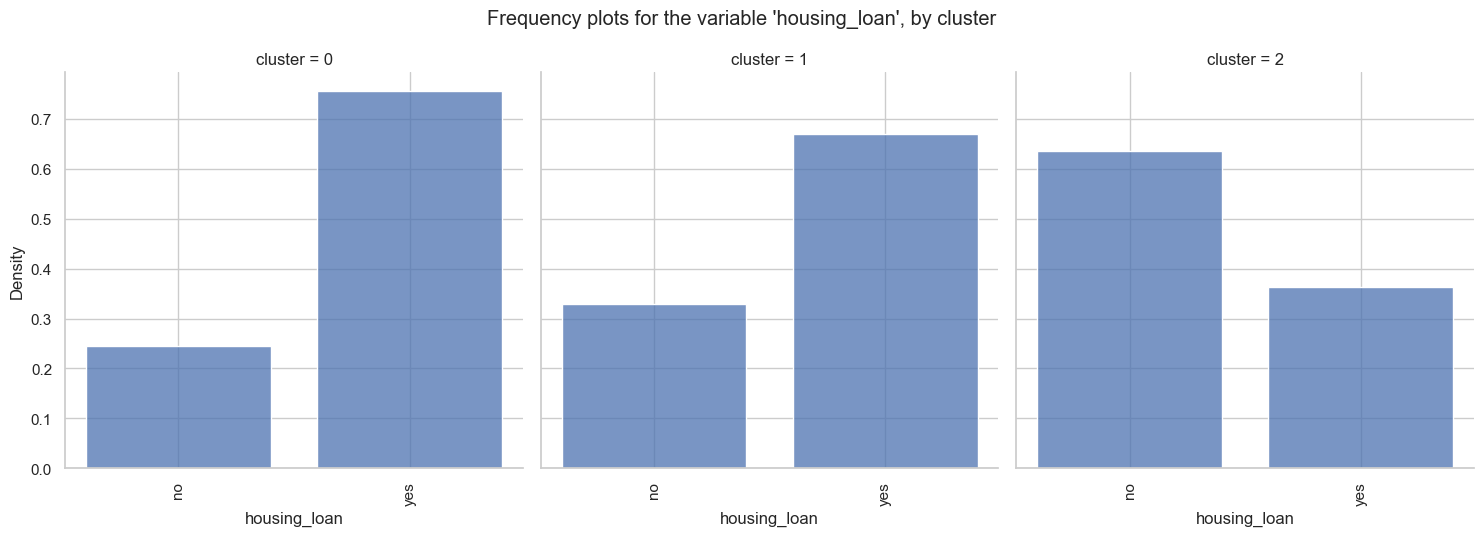

In [23]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='housing_loan', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'housing_loan', by cluster", y=1.05)
plt.show()

Pada cluster 0 dan 1, keduanya mayoritas di isi oleh mereka yang memiliki housing_loan atau mengambil utang rumah seperti KPR sedangkan pada cluster 2 mayoritas di isi oleh mereka yang tidak memiliki housing loan

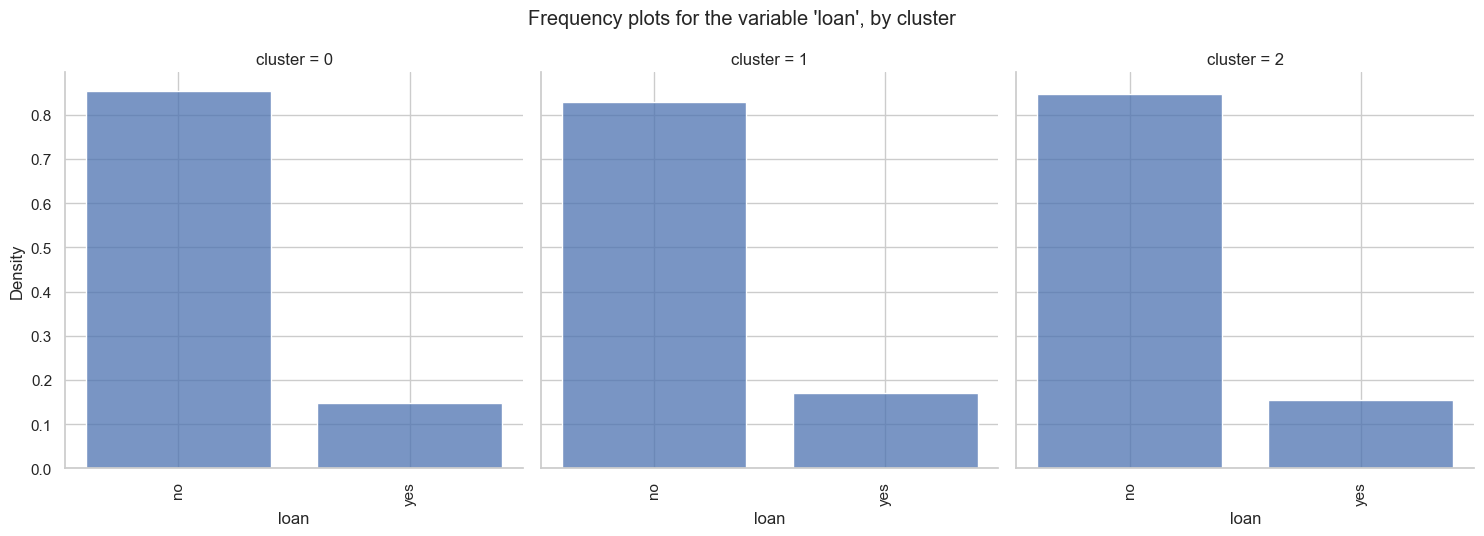

In [24]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='loan', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'loan', by cluster", y=1.05)
plt.show()

Ketiga cluster tidak memiliki perbedaan yang mencolok untuk feature loan

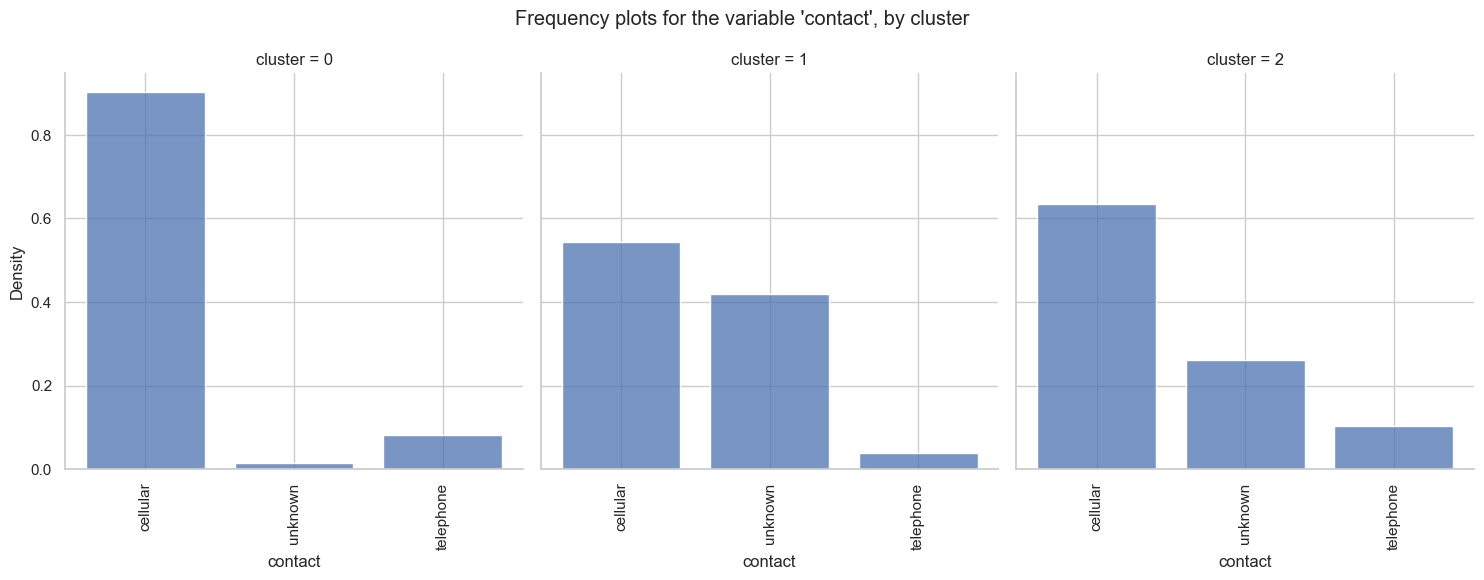

In [25]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='contact', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'contact', by cluster", y=1.05)
plt.show()

Pada variable contact untuk cluster pertama sangat didominasi oleh cellular dimana menempati 80% lebih dari total data dan jenis kontak menggunakan unkown sangat sedikit atau hampir tidak ada, sedangkan untuk cluster 1 mayoritas masih cellular namun tidak terlalu berbeda jauh dengan unkown untuk persentase datanya lalu pada cluster 2 juga masih di dominasi oleh celular. 

In [26]:
generations = []

def get_generation(data):
    if 10 < data <= 25:
        generations.append("Gen Z")
    elif 26 < data <= 43:
        generations.append("Millennials")
    elif 44 < data <= 58:
        generations.append("Gen X")
    elif 59 < data <= 78:
        generations.append("Baby Boomers")
    else:
        generations.append("Silent Generation")

for age_value in df["age"]:
    get_generation(age_value)

df["generation"] = generations

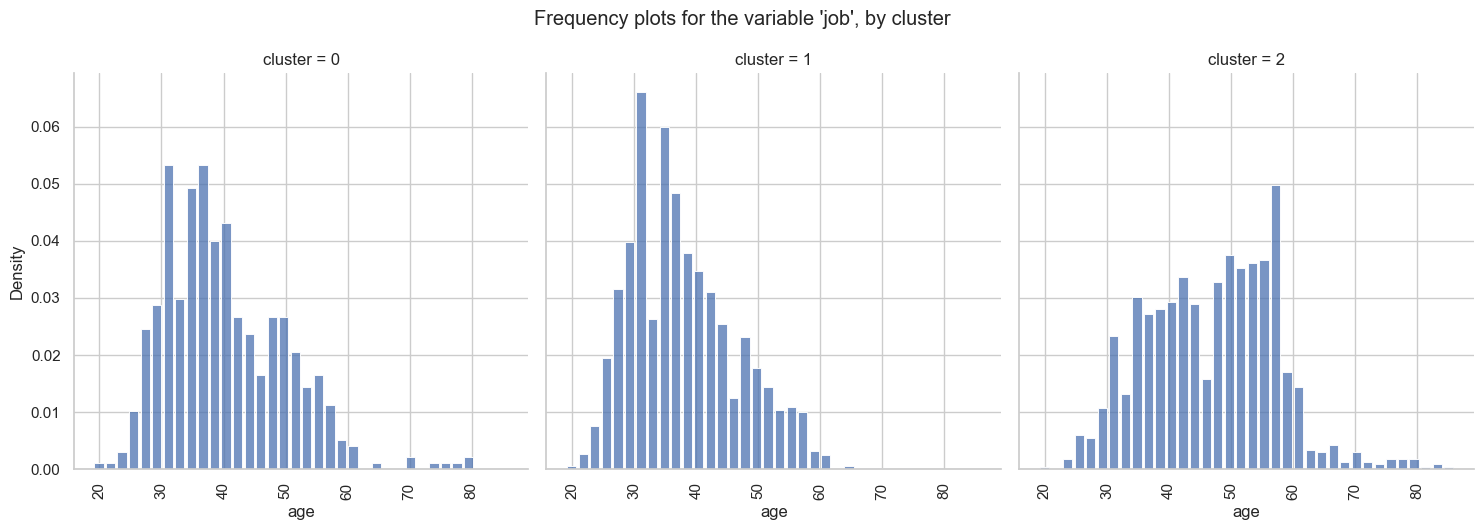

In [27]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='age', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'job', by cluster", y=1.05)
plt.show()

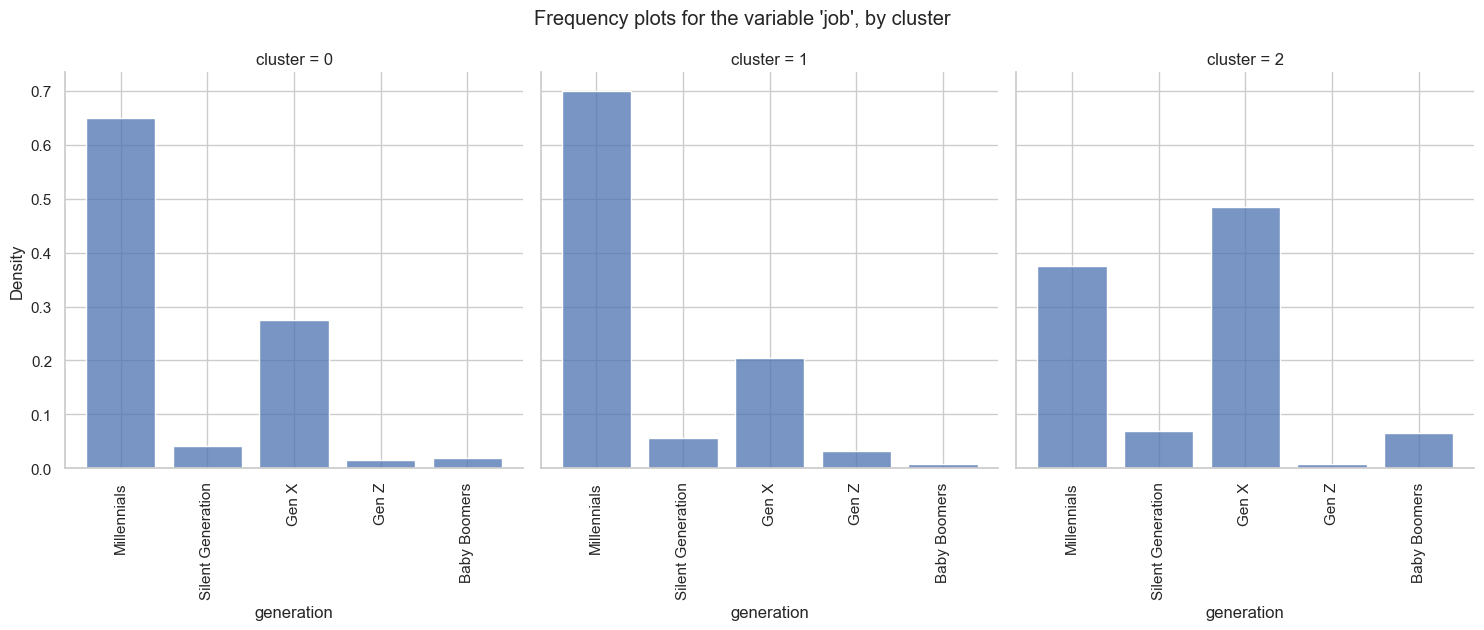

In [28]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='generation', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'job', by cluster", y=1.05)
plt.show()

Untuk umur terdapat beberapa perbedaan yang mencolok yaitu:

- Cluster 0 di mayoritas di isi oleh millenial diatas 60% lalu disusul oleh Gen X yang mendekati 30%, sedangkan untuk silent generation,genz,dan baby boomers sangat kecil 

- Cluster 1 sangat didominasi oleh milennial hingga 70%, dan berbeda dengan cluster 0 dimana untuk gen X hanya sekitar 20% lalu untuk generasi baby boomers hampir tidak ada namun untuk gen z nya mengalami peningkatan dibandingkian pada cluster 0

- Cluster 2 memiliki perbedaan yang mencolok dengan cluster 0 dan 1, dimana pada cluster 2 kebanyakan di isi oleh generasi X hingga 50% dan millenials dibawah 40% yang sangat kontras dengan cluster 0 dan 1. Jika dilihat lagi pada cluster 2 silent generation dan baby boomers meningkat persentasenya dibandingkan cluster 0 dan 1 lalu gen z persentasennya sangat kecil hampir tidak ada

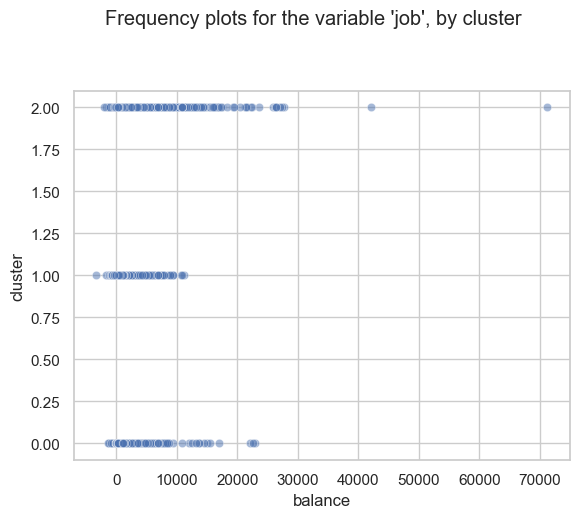

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

g = sns.scatterplot(x='balance', y='cluster', data=df, alpha=0.5)

plt.suptitle("Frequency plots for the variable 'balance', by cluster", y=1.05)
plt.show()


In [44]:
balance_category = []

def get_balance(data):
    if data <= 69:
        balance_category.append("low balance")
    elif data > 1480:
        balance_category.append("high balance")
    else:
        balance_category.append("middle balance")

for balance_value in df["balance"]:
    get_balance(balance_value)

df["balance_category"] = balance_category

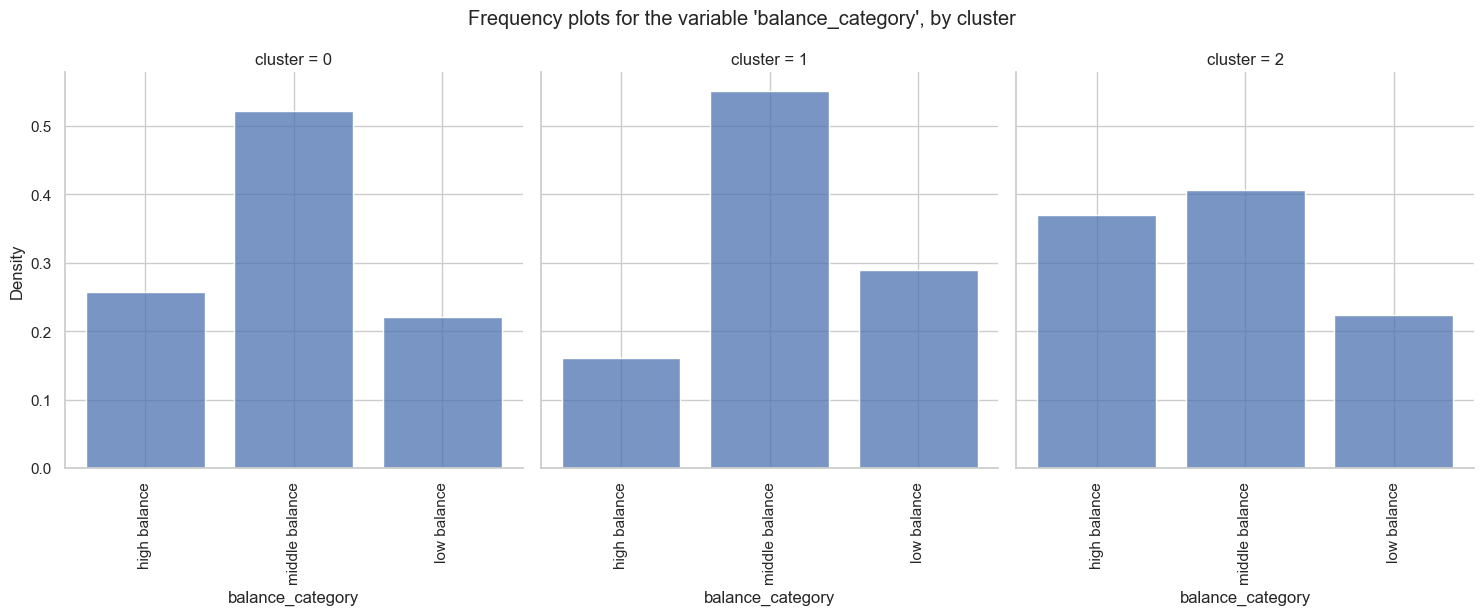

In [45]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='balance_category', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'balance_category', by cluster", y=1.05)
plt.show()

Pada balance tiap cluster terdapat beberapa perbedaan tiap cluster

- Cluster 0 mayoritas di isi oleh mereka yang middle balance atau memiliki penghasilan antara 69 dan 1480, lalu untuk high dan low balancenya cenderung seimbang berada di rentang 20-30 %

- Cluster 1 mayoritas di isi oleh middle balance namun yang menjadi pembeda adalah pada cluster 1 mereka yang low balance atau balance dibawah 69 memiliki persentase hingga 30% dan high balance berada di bawah 20% yang berarti mayoritas pada cluster ini memiliki penghasilan low to middle balance

- Cluster 2 mayoritas di isi oleh middle balance namun yang berbeda dengan cluster lainnya adalah untuk high balancenya memiliki persentase yang mirip dengan middle income yaitu sekitar 35-40 % dan low balancenya berada di bawah 25%

### Campaign Information

In [30]:
temp_day = []
for i in df['day']:
    if i<8:
        temp_day.append("start")
    elif i>23:
        temp_day.append("end")
    else:
        temp_day.append("middle")

df['day_cat'] = temp_day

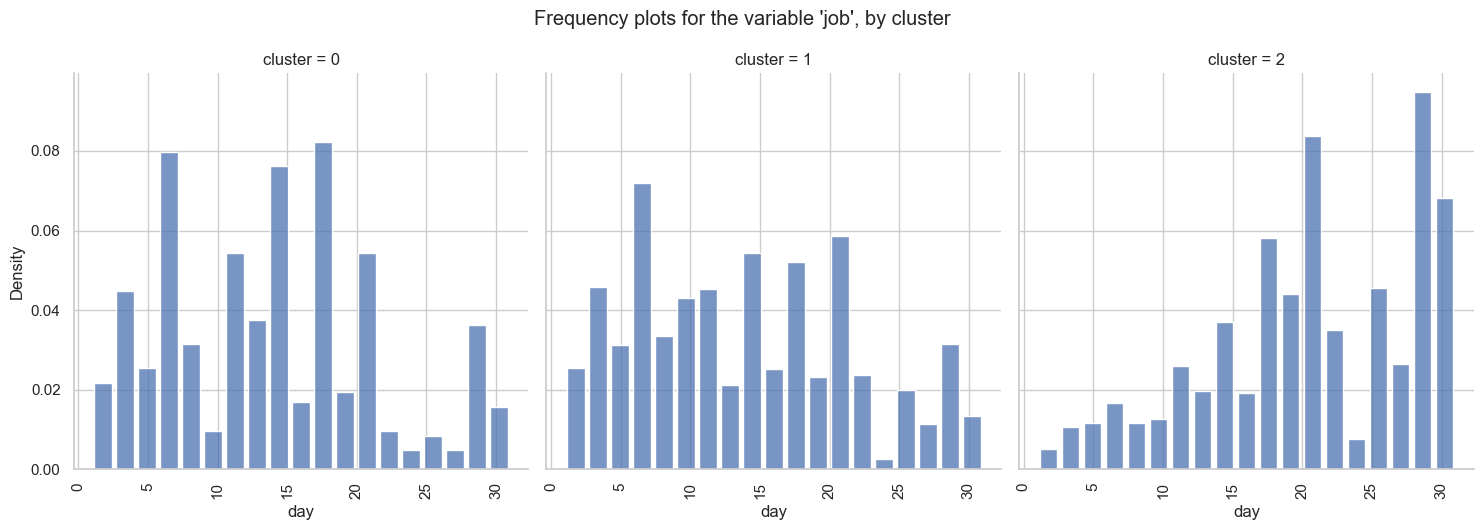

In [31]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='day', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'day', by cluster", y=1.05)
plt.show()

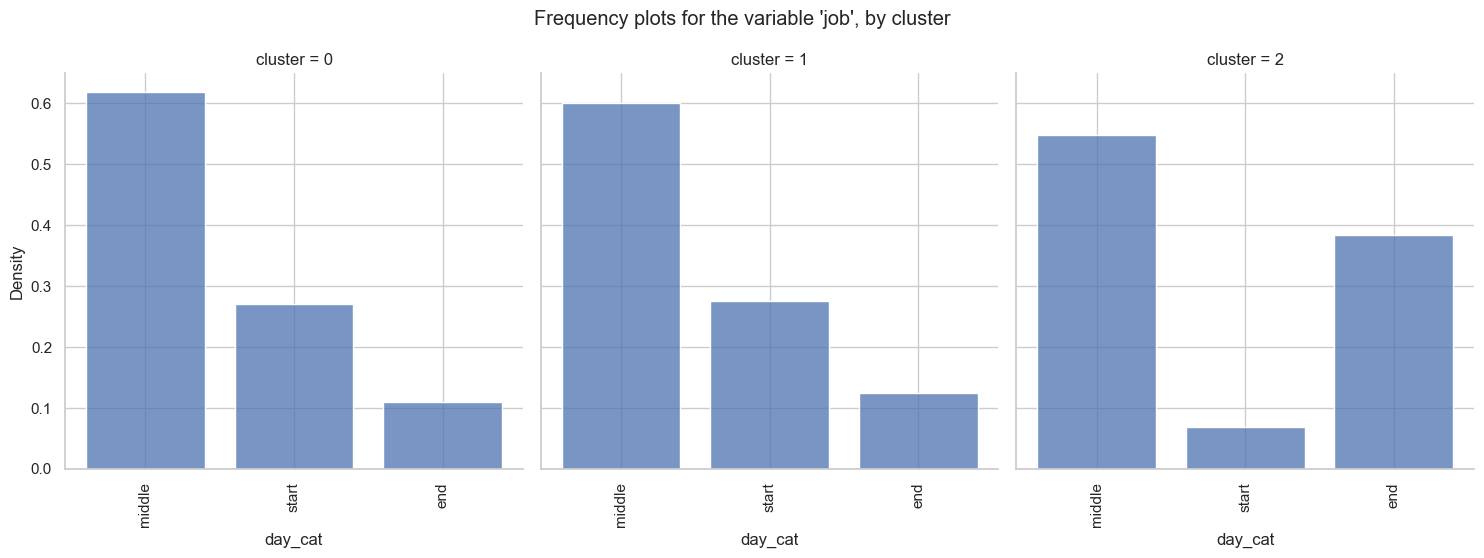

In [32]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='day_cat', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'day category', by cluster", y=1.05)
plt.show()

Terdapat perbedaan hari campaign antara cluster 2 dengan kedua cluster lainnya yaitu pada cluster 2 pada end day memiliki persentase yang lumayan besar dibandingkan kedua cluster lainnya, dan untuk hari mayoritas campaign sama untuk ketiga cluster yaitu pada tengah bulan atau middle

In [33]:
season = []

def get_season(data):
    if data in ["january", "february", "december"]:
        season.append("Winter")
    elif data in ["march", "april", "may"]:
        season.append("Spring")
    elif data in ["june", "july", "august"]:
        season.append("Summer")
    else:
        season.append("Fall")

for month_value in df["month"]:
    get_season(month_value)

df["season"] = season

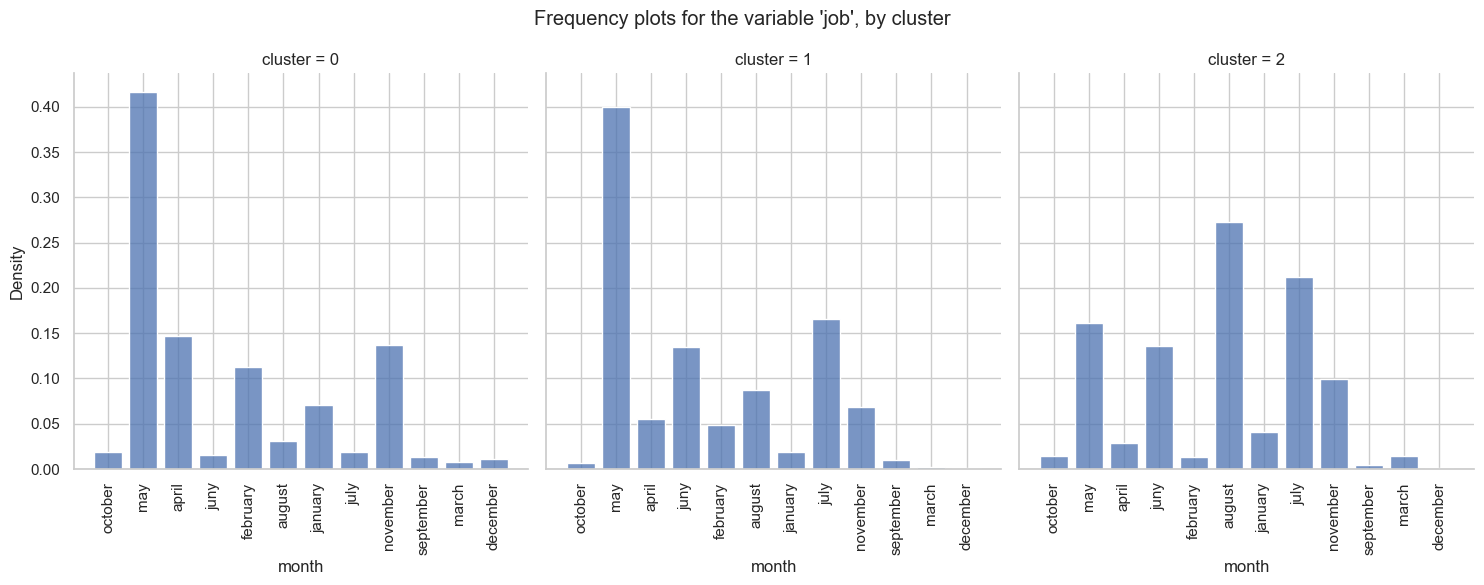

In [34]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='month', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'job', by cluster", y=1.05)
plt.show()

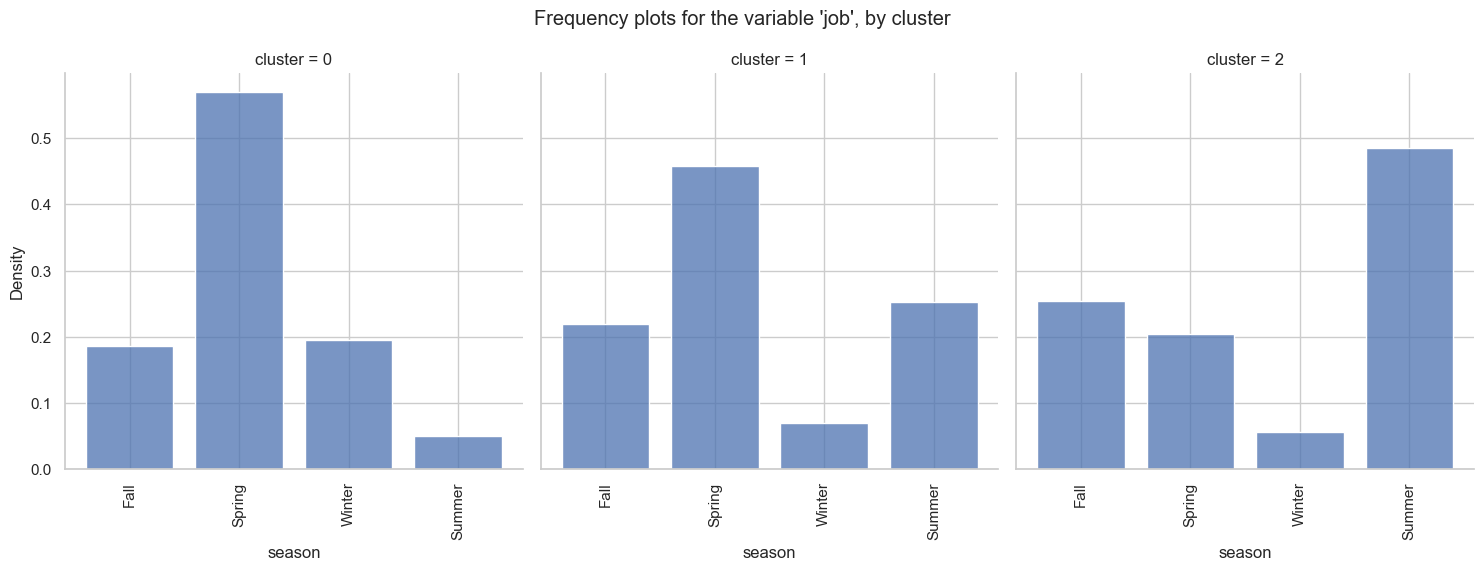

In [35]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='season', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable 'job', by cluster", y=1.05)
plt.show()

In [36]:
avg_duration = df['duration'].mean()

duration_cat = []

def get_duration(data):
    if data < avg_duration:
        duration_cat.append("below average")
    else:
        duration_cat.append("above average")

for duration_value in df["duration"]:
    get_duration(duration_value)

df["duration_cat"] = duration_cat

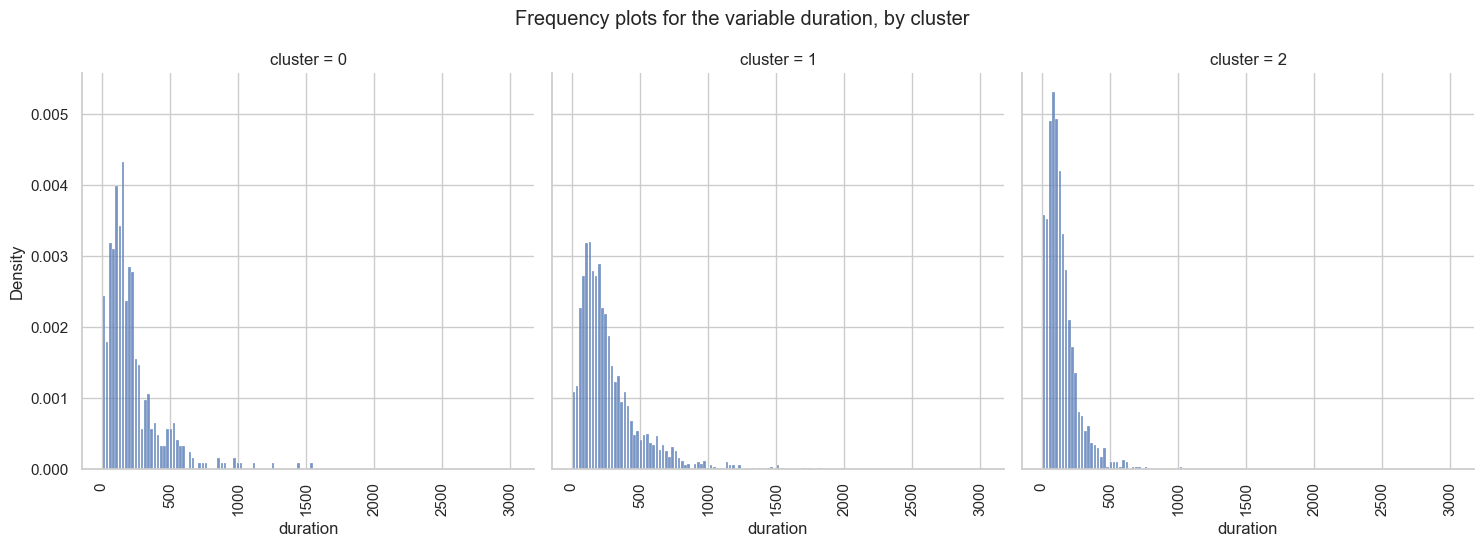

In [37]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='duration', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable duration, by cluster", y=1.05)
plt.show()

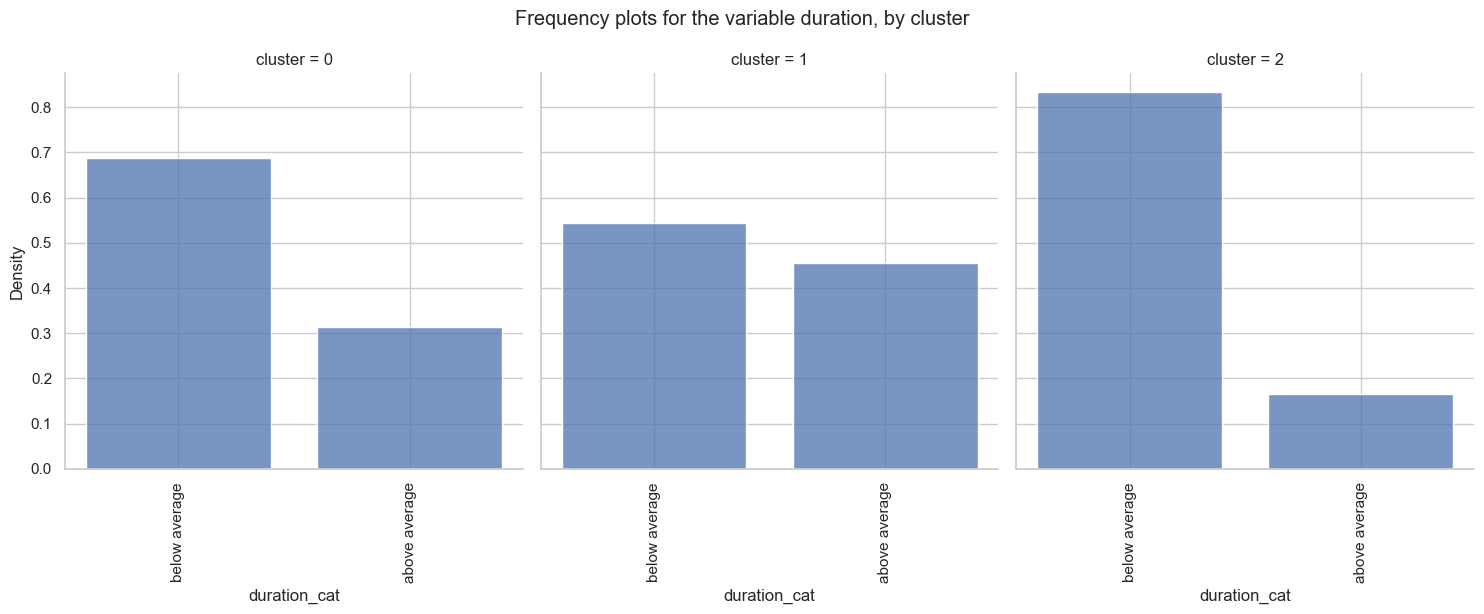

In [38]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='duration_cat', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable duration, by cluster", y=1.05)
plt.show()

Ketiga cluster di isi oleh mereka dengan mayoritas durasi below average karena kita membuat cluster yang didasarkan oleh mereka yang menolah untuk subscribe dan sesuai analisa sebelumnya mereka dengan durasi below average cenderung untuk tidak subscribe dibandingkan dengan mereka yang memiliki durasi lama. Namun yang menjadi pembeda adalah pada cluster 2 ketimpangan antara below average sangat besar dimana below average diatas 80%, lalu yang kedua adalah cluster 0 dengan below average hingga 70%, dan yang paling seimbang adalah cluster 1 dengan below average hanya berada diabwah 55%

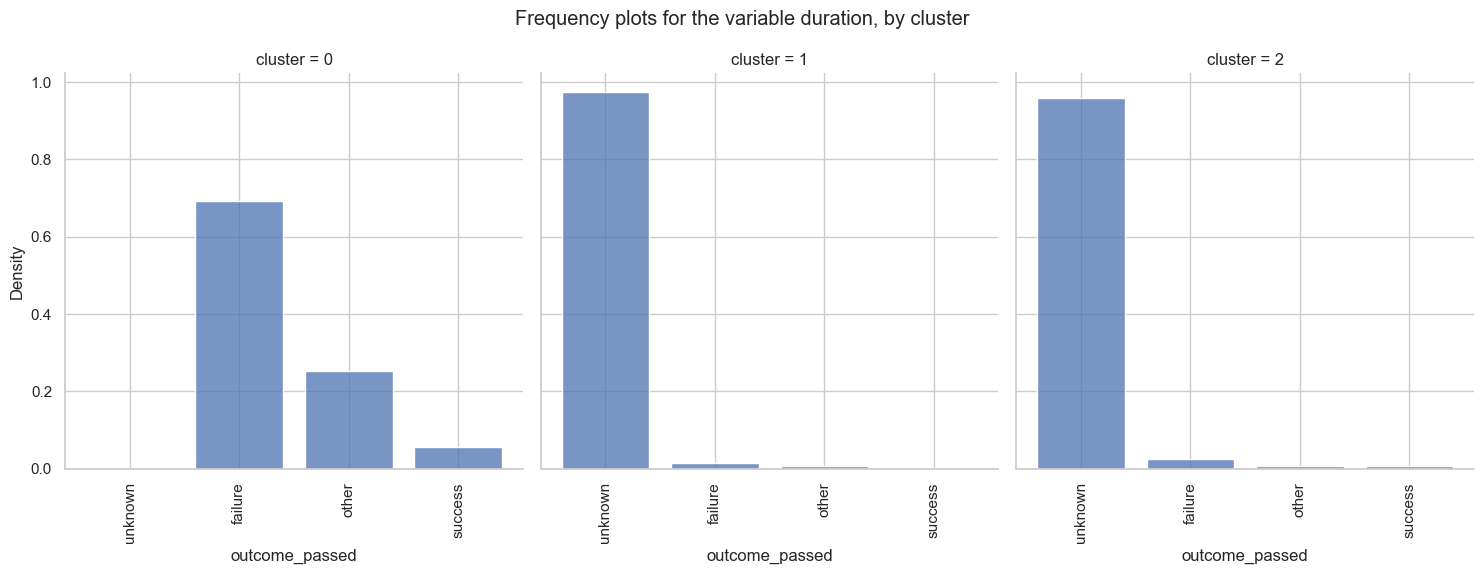

In [39]:
sns.set(style="whitegrid")

g = sns.displot(data=df, x='outcome_passed', col='cluster', multiple="dodge", stat='density', shrink=0.8, common_norm=False, palette="Set3")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable duration, by cluster", y=1.05)
plt.show()

Berdasarkan hasil dari kampanye sebelumnya cluster 0 di isi oleh mereka yang sudah pernah dilakukan campaign namun menolak, sedangkan pada kedua cluster lainnya di isi oleh mereka yang masih belum diberikan campaign sebelumnya

In [ ]:
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.suptitle("Frequency plots for the variable duration, by cluster", y=1.05)
plt.show()

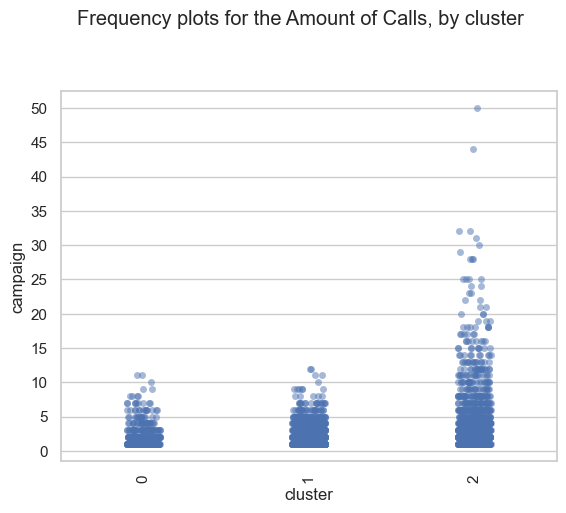

In [53]:
sns.set(style="whitegrid")

g = sns.stripplot(x="cluster", y="campaign", data=df, jitter=True, alpha=0.5)

g.set_yticks(range(0, df['campaign'].max() + 1, 5)) 
g.set_yticklabels(g.get_yticks())
g.set_xticklabels(g.get_xticklabels(), rotation=90)


plt.suptitle("Frequency plots for the Amount of Calls, by cluster", y=1.05)
plt.show()

Pada amount of call atau seberapa sering dilakukan panggilan telepon kepada client, didapatkan untuk cluster 2 memiliki panggilan diatas 5 kali bahkan masih banyak yang berada diatas 15 kali panggilan sedangkan untuk cluster 0 dan 1 rata" berada dibawah 5 kali panggilan dan tidak ada yang berada diatas 15 panggilan

## Kesimpulan